In [1]:
from cp import data, visualize, validate, exchangeable, cv, logger as _logger
import matplotlib.pyplot as plt
import numpy as np
SEED: int = 123
np.random.seed(SEED)
MISCOVERAGE: float = 0.10 # MISCOVERAGE = alpha # CONFIDENCE = 1-alpha 
logger = _logger.Logger()

# Exchangeable data

## Toy problem

In [2]:
N_SAMPLES: int = 5000
NOISE: float = 0.1
toy_problem = data.ToyProblem(noise=NOISE, N=N_SAMPLES)

### First dataset
$$ Y = \sin{2X} + \epsilon \left( U - \frac{1}{2} \right)$$
Being $X \in [0, 2\pi)$, $U\in [0, 1]$ a random variable following a uniform distribution and $\epsilon$ a small quantity which tunes the noise level.
Namely, we have:
- Single Variable Input
- Homoscedastic Uncertainty
- Low Uncertainty
- Trigonometric Relationships between Input and Output

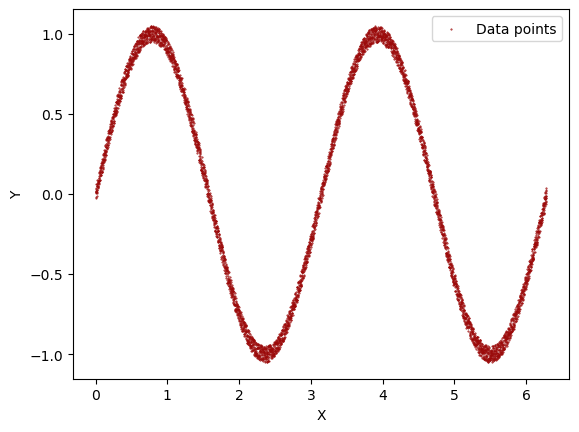

In [3]:
X, y = (toy_problem.first_data)
visualize.data({'X': X, 'y': y});
X_train, X_test, y_train, y_test = data.split(X, y, seed=SEED)

We will compare three methods of quantifying the uncertainty: split (`SCP`), Jackknife+ after Bootstrap (`J+aB`), CQR (`CQR`).

In [4]:
from mapie.subsample import Subsample

strategies_names = {
    'SCP': 'Split Conformal Prediction',
    'CV+': 'Cross Validation +',
    'J+aB': 'Jackknife+ after Bootstrapping',
    # 'CQR': 'Conformalized Quantile Regression'
}
strategies_params = {
    'SCP': {'method': 'base', 'cv': "split", "random_state": SEED},
    'CV+': {'method': "plus", 'cv': 10, "random_state": SEED},
    'J+aB': {'method': "plus", 'cv': Subsample(n_resamplings=50), "random_state": SEED},
    # 'CQR': {'method': "quantile", 'cv': "split", 'alpha': MISCOVERAGE}
}

Let us perform a polynomial fit and, then, assess its uncertainty.

In [5]:
DEGREE: int = 10

from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

params = {
    'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 
    'miscoverage': MISCOVERAGE, 'seed': SEED
}
base_estimators = {
    'SCP': Pipeline([('poly', PolynomialFeatures(degree=DEGREE)), ('linear', LinearRegression())]),
    'CV+': Pipeline([('poly', PolynomialFeatures(degree=DEGREE)), ('linear', LinearRegression())]),
    'J+aB': Pipeline([('poly', PolynomialFeatures(degree=DEGREE)), ('linear', LinearRegression())]),
    # 'CQR': Pipeline([('poly', PolynomialFeatures(degree=DEGREE)), ('linear', QuantileRegressor(solver="highs"))])
} 

y_pred, int_pred, mapie_estimator = exchangeable.train_strategies(
    params, base_estimators, strategies_params, strategies_names)

05/18/2024 08:46:48 PM     INFO >> Training Split Conformal Prediction
05/18/2024 08:46:48 PM     INFO >> Training Cross Validation +
05/18/2024 08:46:48 PM     INFO >> Training Jackknife+ after Bootstrapping


In [6]:
# we could also predict the in-training samples
y_pred_train, int_pred_train = {}, {}

for _strat, _name in strategies_names.items():
    logger.info(f"Inferring in-training results for {_name}")
    if _strat != 'CQR':
        y_pred_train[_strat], int_pred_train[_strat] = mapie_estimator[_strat].predict(X_train, alpha=MISCOVERAGE)
    else:
        y_pred_train[_strat], int_pred_train[_strat] = mapie_estimator[_strat].predict(X_train)

05/18/2024 08:46:49 PM     INFO >> Inferring in-training results for Split Conformal Prediction
05/18/2024 08:46:49 PM     INFO >> Inferring in-training results for Cross Validation +
05/18/2024 08:46:50 PM     INFO >> Inferring in-training results for Jackknife+ after Bootstrapping


Let's plot the results for the test set.

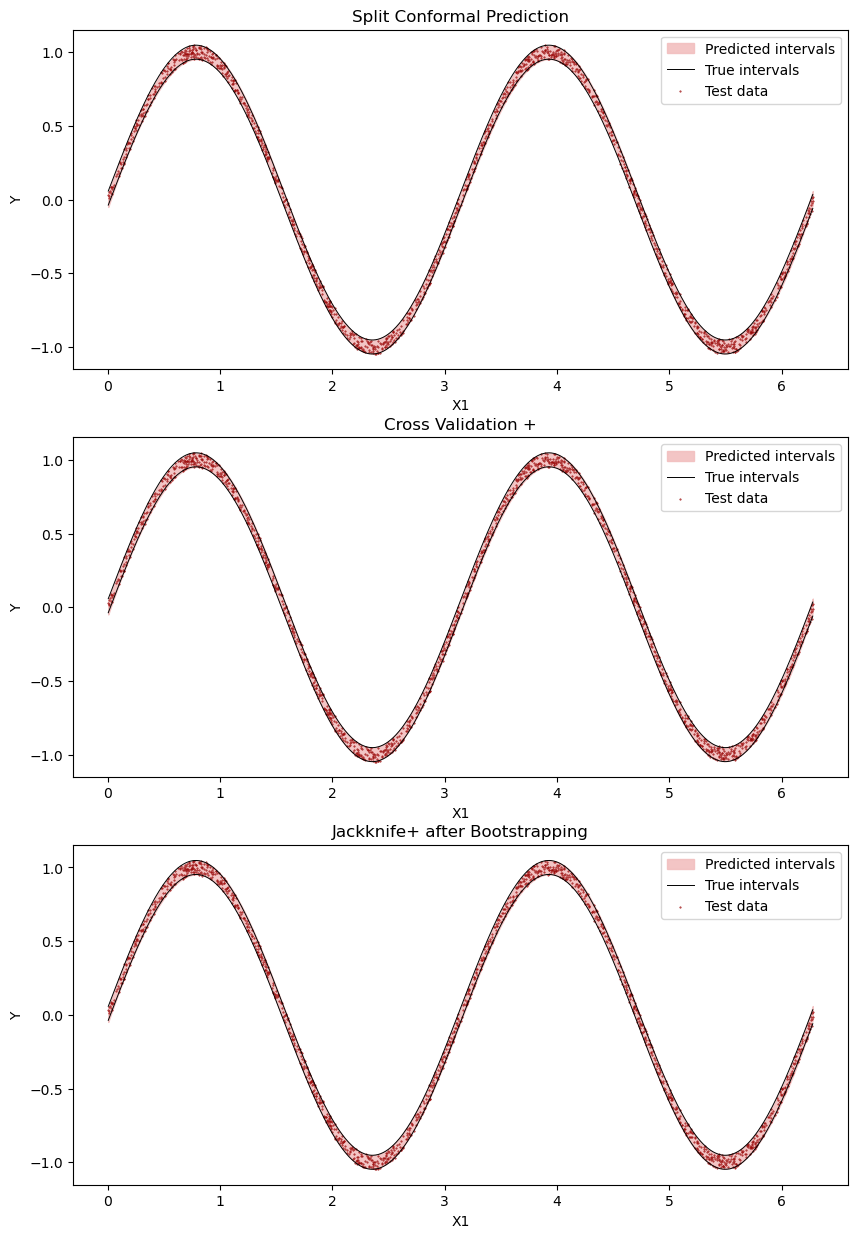

In [7]:
fig, axs = plt.subplots(nrows=len(base_estimators), figsize=(10, 15));

# True intervals
_y_true_up, _y_true_low = (toy_problem.first_intervals(X_test, MISCOVERAGE))

for _i, _strat in enumerate(strategies_names.keys()):
    # Predicted intervals
    _y_pred_low = int_pred[_strat][:, 0, 0].ravel()
    _y_pred_up = int_pred[_strat][:, 1, 0].ravel()

    # Visualize
    axs[_i] = visualize.data(
        {'X': X_test, 'y': y_test},
        bounds={
            'X': X_test.ravel(), 
            'y_low': _y_pred_low, 
           'y_up': _y_pred_up},
        intervals={
            'X': X_test.ravel(), 
            'y_low': _y_true_low, 
            'y_up': _y_true_up},
        xlabel='X1',
        title=strategies_names[_strat], 
        points_label='Test data',
        ax=axs[_i]
        )

Let us assess some metrics and plot different validation figures:

- **Average goodness**

05/18/2024 08:46:52 PM     INFO >> Validating SCP coverage
05/18/2024 08:46:52 PM     INFO >> Validating CV+ coverage
05/18/2024 08:46:52 PM     INFO >> Validating J+aB coverage
05/18/2024 08:46:52 PM     INFO >> Validating SCP width
05/18/2024 08:46:52 PM     INFO >> Validating CV+ width
05/18/2024 08:46:52 PM     INFO >> Validating J+aB width
05/18/2024 08:46:52 PM     INFO >> Validating SCP RMSE
05/18/2024 08:46:52 PM     INFO >> Validating CV+ RMSE
05/18/2024 08:46:52 PM     INFO >> Validating J+aB RMSE
05/18/2024 08:46:52 PM     INFO >> Validating SCP CWC
05/18/2024 08:46:52 PM     INFO >> Validating CV+ CWC
05/18/2024 08:46:52 PM     INFO >> Validating J+aB CWC


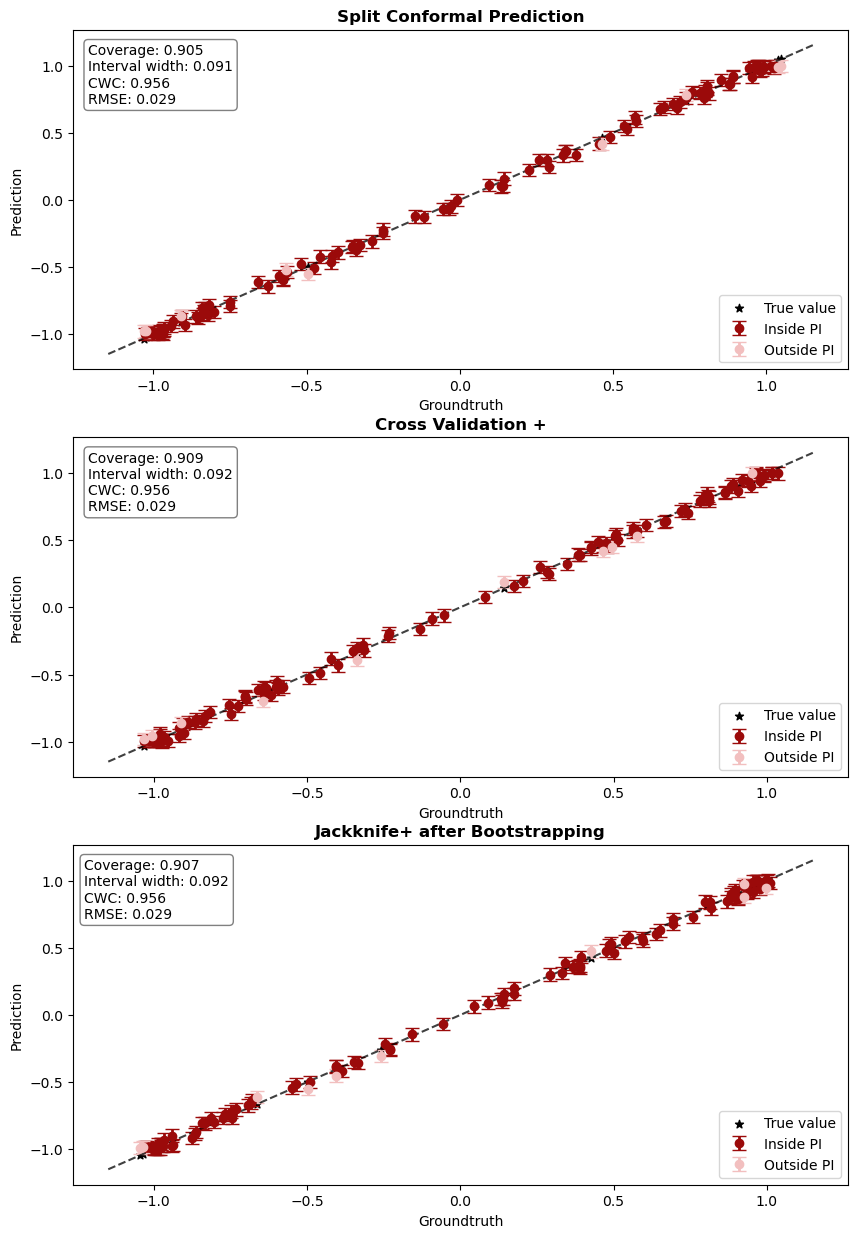

In [8]:
fig, axs = plt.subplots(nrows=len(base_estimators), figsize=(10, 15));

coverages: dict = validate.coverage(int_pred, y_test)
widths: dict = validate.width(int_pred)
rmse: dict = validate.rmse(y_pred, y_test)
cwc: dict = validate.cwc(int_pred, y_test, MISCOVERAGE)

for _i, _strat in enumerate(strategies_names.keys()):
    # Predicted intervals
    _y_pred_low = int_pred[_strat][:, 0, 0].ravel()
    _y_pred_up = int_pred[_strat][:, 1, 0].ravel()

    # Visualize
    axs[_i] = visualize.goodness(
        y_test, y_pred[_strat],
        _y_pred_low, 
        _y_pred_up,
        coverages[_strat],
        widths[_strat],
        rmse[_strat],
        cwc[_strat],
        ax=axs[_i],
        subsample=0.075,
        title=strategies_names[_strat], 
    )

For visualization purposes, note that just a 7.5% of the test data was shown. 

- Marginal vs. conditional coverage: **width occurrence**

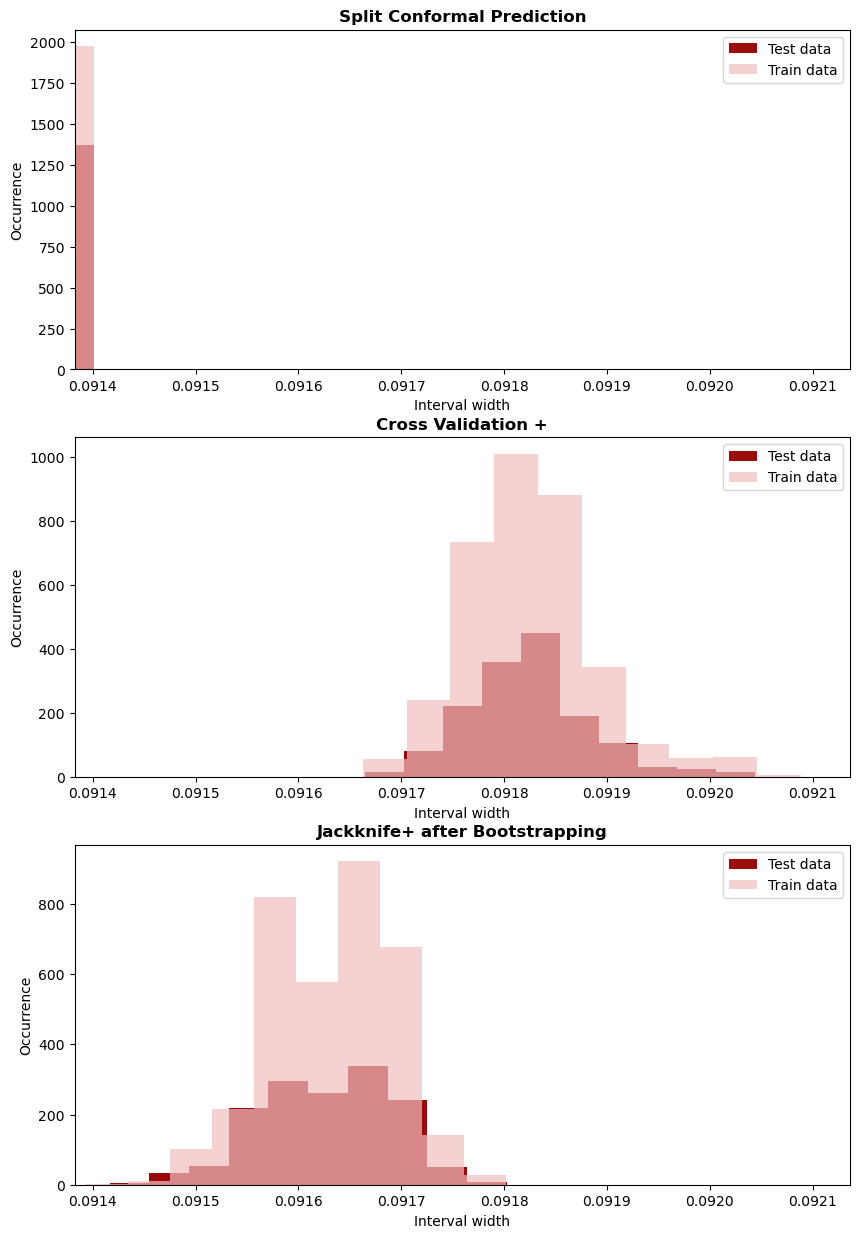

In [9]:
fig, axs = plt.subplots(nrows=len(base_estimators), figsize=(10, 15));
_x_max = (1+1e-3) * np.max([np.abs(int_pred[_strat][:, 0, 0] - int_pred[_strat][:, 1, 0]) for _strat in int_pred.keys()]) 
_x_min = np.min([np.abs(int_pred[_strat][:, 0, 0] - int_pred[_strat][:, 1, 0]) for _strat in int_pred.keys()])

for _i, _strat in enumerate(base_estimators.keys()):
    # Visualize
    axs[_i] = visualize.width_size_occurrence(
        int_pred[_strat],
        train_intervals=int_pred_train[_strat],
        num_bins=10,
        ax=axs[_i],
        x_lim=[_x_min, _x_max],
        title=strategies_names[_strat], 
    )

- Marginal vs. conditional coverage: **coverage vs. width**
    - Since `SCP` provides constant-width intervals, its plot is omitted.

05/18/2024 08:46:52 PM  WARNING >> This metric should be used only with non constant intervals (intervals of different sizes), with constant intervals the result may be misinterpreted.
05/18/2024 08:46:52 PM  WARNING >> Size-Stratified Coverage score set to 0 for SCP
05/18/2024 08:46:52 PM     INFO >> Validating CV+ Size-Stratified Coverage
05/18/2024 08:46:52 PM     INFO >> Validating J+aB Size-Stratified Coverage
05/18/2024 08:46:52 PM     INFO >> Validating SCP HSIC coefficient
05/18/2024 08:46:53 PM     INFO >> Validating CV+ HSIC coefficient
05/18/2024 08:46:53 PM     INFO >> Validating J+aB HSIC coefficient


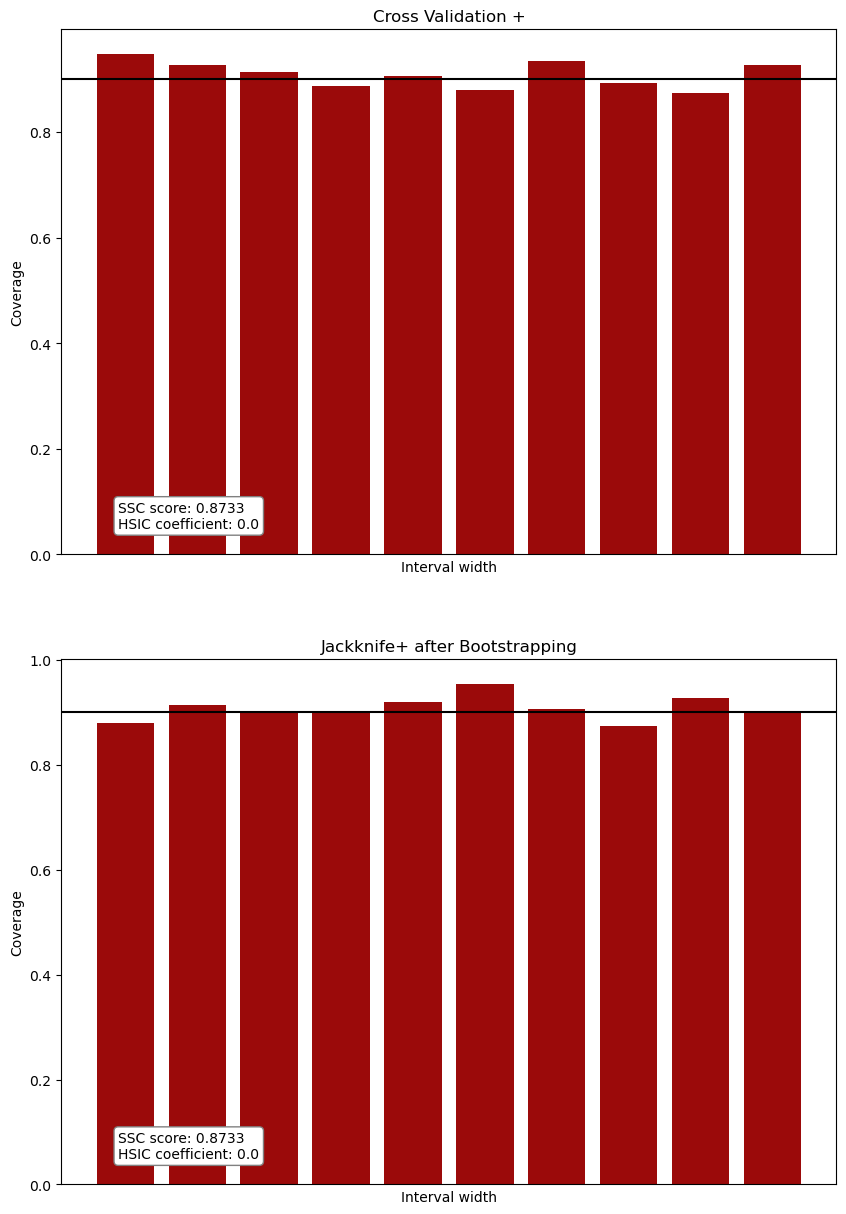

In [10]:
_strategies = [_s for _s in strategies_names.keys() if _s != 'SCP']
NUM_BINS: int = 10

fig, axs = plt.subplots(nrows=len(_strategies), figsize=(10, 15));

cond_coverages: dict = validate.cond_coverage(int_pred, y_test, num_bins=NUM_BINS)
hsic_coefficients: dict = validate.hsic_coefficient(int_pred, y_test) 

for _i, _strat in enumerate(_strategies):
    axs[_i] = visualize.coverage_by_width(
        y_test, int_pred[_strat], MISCOVERAGE,
        cond_coverages[_strat],
        hsic_coefficients[_strat],
        num_bins=NUM_BINS,
        ax=axs[_i],
        title=strategies_names[_strat], 
    )

For a more detailed interpretation of SSC score and the HSIC coefficient, one can refer to this [page](https://mapie.readthedocs.io/en/stable/examples_regression/2-advanced-analysis/plot_conditional_coverage.html). Below a list with the all metrics shown so far is represented.

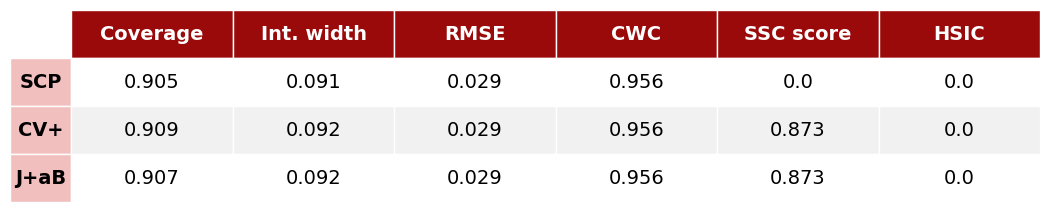

In [11]:
metrics_df = visualize.dicts_to_dataframe(
    {'Coverage': coverages, 'Int. width': widths, 
     'RMSE': rmse, 'CWC': cwc, 
     'SSC score': cond_coverages, 
     'HSIC': hsic_coefficients})

visualize.dataframe_to_png(metrics_df, 'output/metrics-table.png')

- **Coverage sougth for different values of $\alpha$**: and, finally, a visualization which displays the performance of each strategy when $\alpha$ is changed

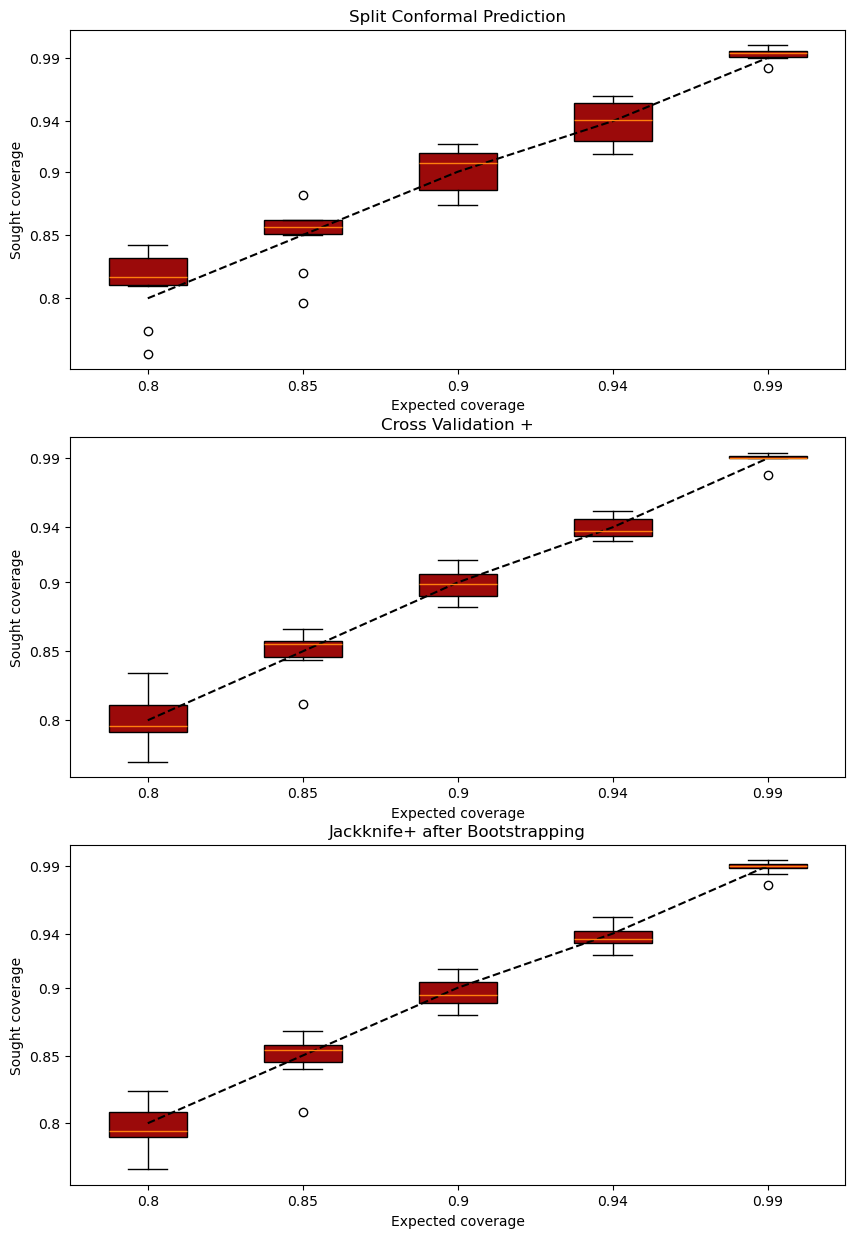

In [12]:
coverages_dict, miscoverages_list = {}, np.round(np.linspace(0.01, 0.20, 5), 2)
for _strat, base_estimator in base_estimators.items():
    coverages_dict[_strat] = cv.coverage_in_function_of_alpha(X, y, miscoverages_list, 
                                                              base_estimator, strategies_params[_strat], 
                                                              _strat, SEED, silent=True, K=10)
    
fig, axs = plt.subplots(nrows=len(base_estimators), figsize=(10, 15));

for _i, _strat in enumerate(base_estimators):
    axs[_i] = visualize.coverage_by_alpha(
        coverages_dict[_strat], 
        miscoverages_list, 
        strategies_names[_strat],
        ax=axs[_i]
        )

### Second dataset
$$ Y = \sin{2X_1} + 5\epsilon \left(U - \frac{1}{2}\right) (1 - \sin{X_2})\cos{X_2} $$
Being $X_1,X_2 \in [0, 2\pi)$, $U\in [0, 1]$ a random variable following a uniform distribution and $\epsilon$ a small quantity which tunes the noise level.
Namely, we have:
- Two Variable Input
    - Note $X_1$ mainly determines the prediction, while $X_2$ determines the direction and magnitude of uncertainty.
- Heterocedastic Uncertainty
    - The variance of $Y$ depends on the $X_2$ feature space and it is not constant
- High Uncertainty
    - At most, five times bigger than before
- Trigonometric Relationships between Input and Output

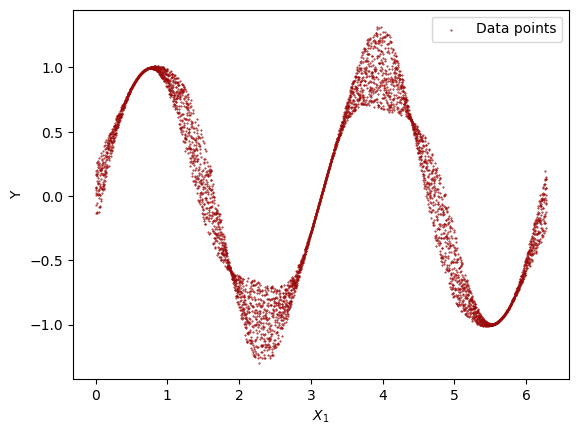

In [13]:
X, y = (toy_problem.second_data)
visualize.data({'X': X['X1'], 'y': y}, xlabel='$X_1$');
X_train, X_test, y_train, y_test = data.split(X, y, seed=SEED)

In [14]:
DEGREE: int = 10

params = {
    'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 
    'miscoverage': MISCOVERAGE, 'seed': SEED
}
base_estimators = {
    'SCP': Pipeline([('poly', PolynomialFeatures(degree=DEGREE)), ('linear', LinearRegression())]),
    'CV+': Pipeline([('poly', PolynomialFeatures(degree=DEGREE)), ('linear', LinearRegression())]),
    'J+aB': Pipeline([('poly', PolynomialFeatures(degree=DEGREE)), ('linear', LinearRegression())]),
    # 'CQR': Pipeline([('poly', PolynomialFeatures(degree=DEGREE)), ('linear', QuantileRegressor(solver="highs"))])
} 

y_pred, int_pred, mapie_estimator = exchangeable.train_strategies(
    params, base_estimators, strategies_params, strategies_names)

05/18/2024 08:51:07 PM     INFO >> Training Split Conformal Prediction
05/18/2024 08:51:07 PM     INFO >> Training Cross Validation +
05/18/2024 08:51:08 PM     INFO >> Training Jackknife+ after Bootstrapping


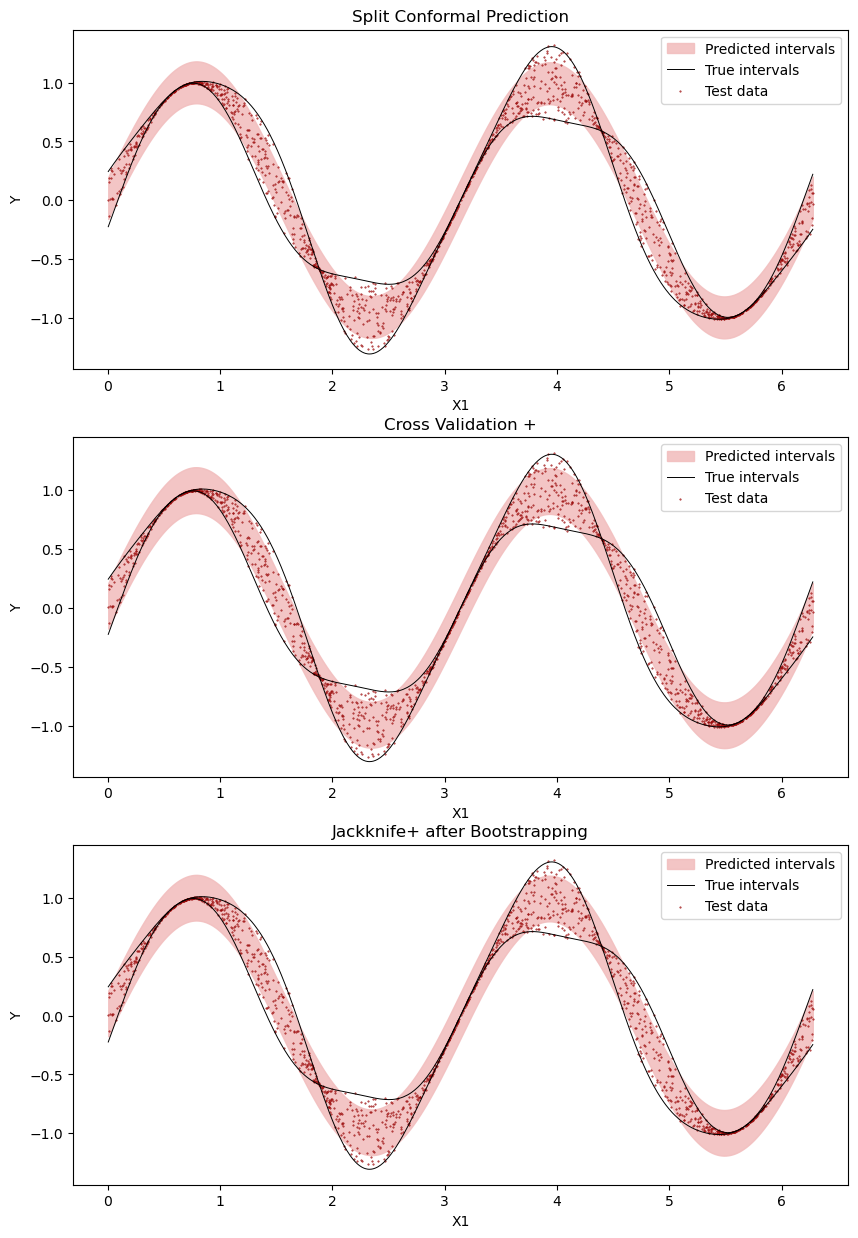

In [15]:
fig, axs = plt.subplots(nrows=len(base_estimators), figsize=(10, 15));

# True intervals
_y_true_up, _y_true_low = (toy_problem.second_intervals(X_test[:, 0], X_test[:, 1], MISCOVERAGE))

for _i, _strat in enumerate(strategies_names.keys()):
    # Predicted intervals
    _y_pred_low = int_pred[_strat][:, 0, 0].ravel()
    _y_pred_up = int_pred[_strat][:, 1, 0].ravel()

    # Visualize
    axs[_i] = visualize.data(
        {'X': X_test[:, 0], 'y': y_test},
        bounds={
            'X': X_test[:, 0].ravel(), 
            'y_low': _y_pred_low, 
            'y_up': _y_pred_up},
        intervals={
            'X': X_test[:, 0].ravel(), 
            'y_low': _y_true_low, 
            'y_up': _y_true_up},
        xlabel='X1',
        title=strategies_names[_strat], 
        points_label='Test data',
        ax=axs[_i])

- **Average goodness**

05/18/2024 08:51:09 PM     INFO >> Validating SCP coverage
05/18/2024 08:51:09 PM     INFO >> Validating CV+ coverage
05/18/2024 08:51:09 PM     INFO >> Validating J+aB coverage
05/18/2024 08:51:09 PM     INFO >> Validating SCP width
05/18/2024 08:51:09 PM     INFO >> Validating CV+ width
05/18/2024 08:51:09 PM     INFO >> Validating J+aB width
05/18/2024 08:51:09 PM     INFO >> Validating SCP RMSE
05/18/2024 08:51:09 PM     INFO >> Validating CV+ RMSE
05/18/2024 08:51:09 PM     INFO >> Validating J+aB RMSE
05/18/2024 08:51:09 PM     INFO >> Validating SCP CWC
05/18/2024 08:51:09 PM     INFO >> Validating CV+ CWC
05/18/2024 08:51:09 PM     INFO >> Validating J+aB CWC


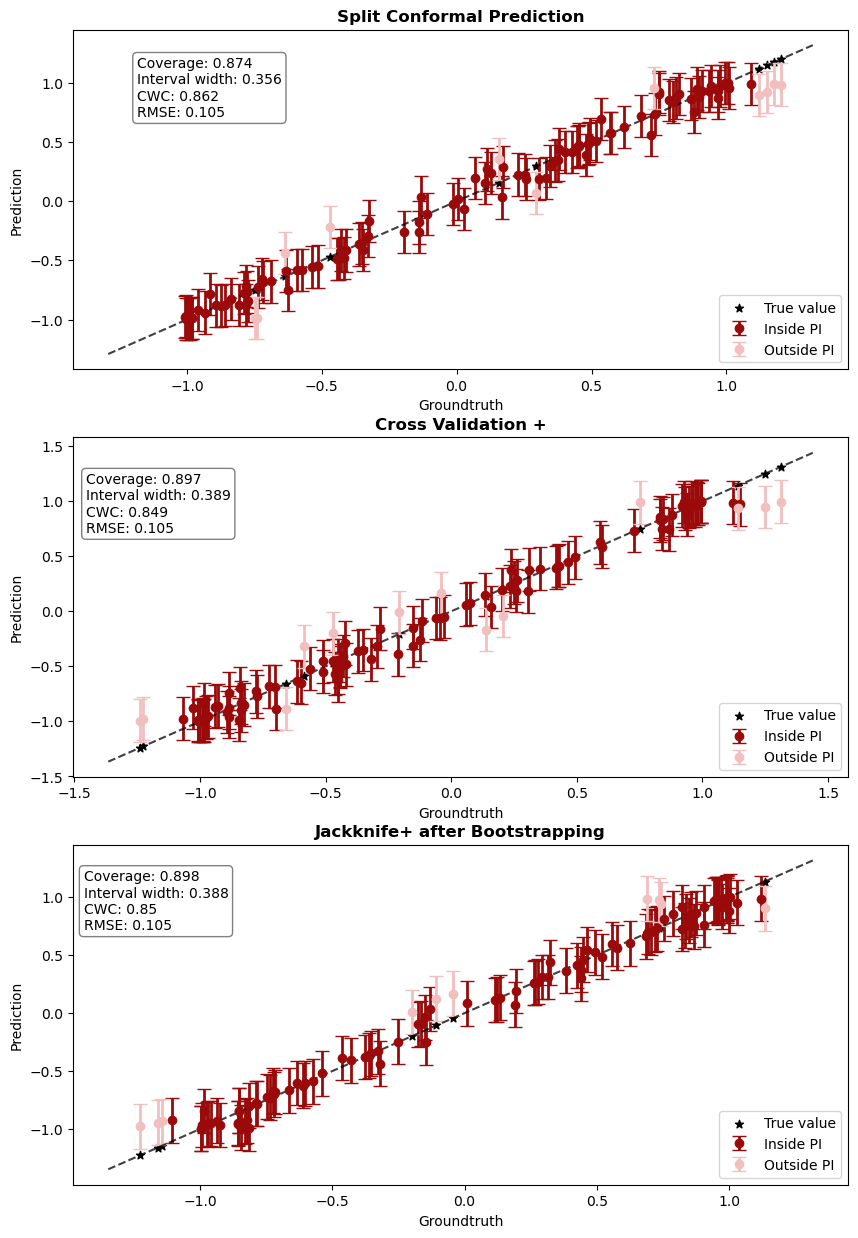

In [16]:
fig, axs = plt.subplots(nrows=len(base_estimators), figsize=(10, 15));

coverages: dict = validate.coverage(int_pred, y_test)
widths: dict = validate.width(int_pred)
rmse: dict = validate.rmse(y_pred, y_test)
cwc: dict = validate.cwc(int_pred, y_test, MISCOVERAGE)

for _i, _strat in enumerate(strategies_names.keys()):
    # Predicted intervals
    _y_pred_low = int_pred[_strat][:, 0, 0].ravel()
    _y_pred_up = int_pred[_strat][:, 1, 0].ravel()

    # Visualize
    axs[_i] = visualize.goodness(
        y_test, y_pred[_strat],
        _y_pred_low, 
        _y_pred_up,
        coverages[_strat],
        widths[_strat],
        rmse[_strat],
        cwc[_strat],
        ax=axs[_i],
        subsample=0.075,
        title=strategies_names[_strat], 
    )

- Marginal vs. conditional coverage: **width occurrence**

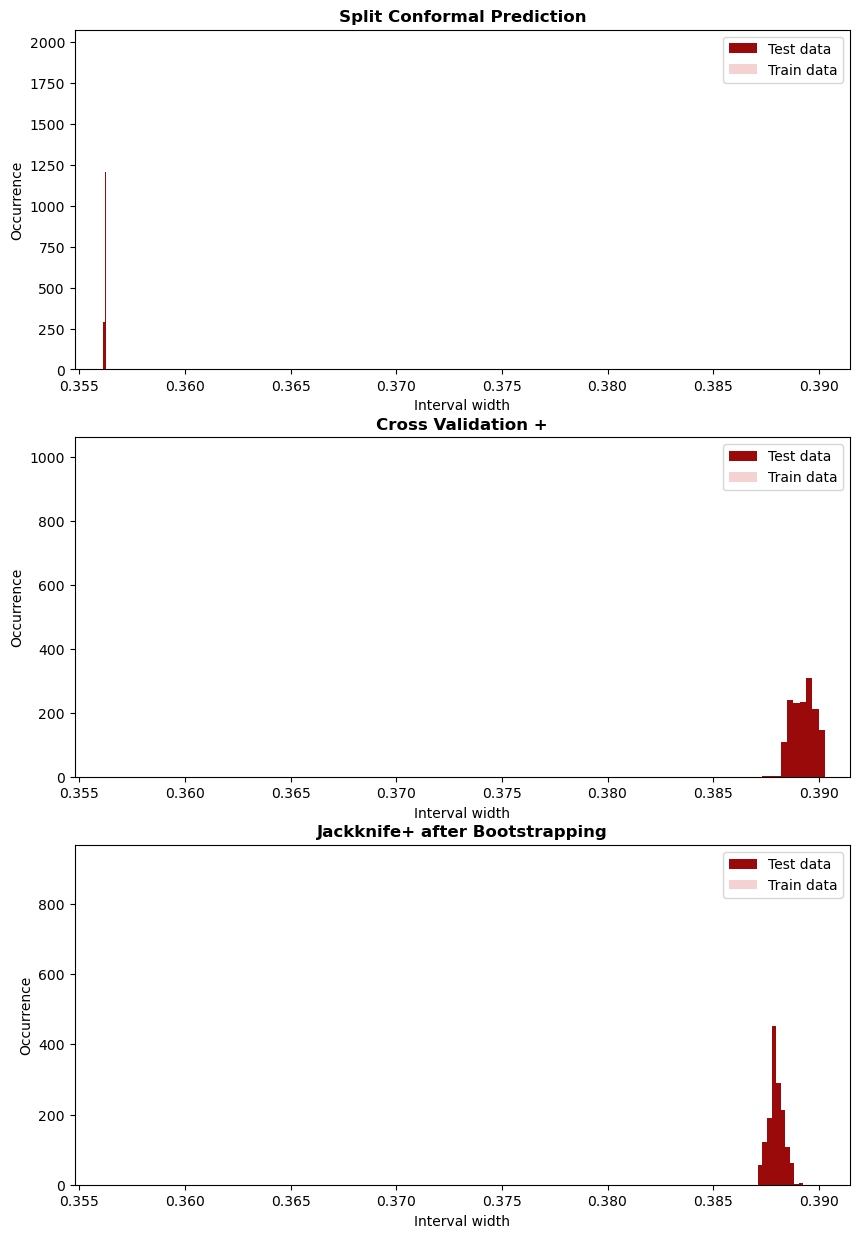

In [17]:
fig, axs = plt.subplots(nrows=len(base_estimators), figsize=(10, 15));
_x_max = (1+ 3 * 1e-3) * np.max([np.abs(int_pred[_strat][:, 0, 0] - int_pred[_strat][:, 1, 0]) for _strat in int_pred.keys()]) 
_x_min = (1- 4 * 1e-3) * np.min([np.abs(int_pred[_strat][:, 0, 0] - int_pred[_strat][:, 1, 0]) for _strat in int_pred.keys()])

for _i, _strat in enumerate(base_estimators.keys()):
    # Visualize
    axs[_i] = visualize.width_size_occurrence(
        int_pred[_strat],
        train_intervals=int_pred_train[_strat],
        num_bins=10,
        ax=axs[_i],
        x_lim=[_x_min, _x_max],
        title=strategies_names[_strat], 
    )

- Marginal vs. conditional coverage: **coverage vs. width**
    - Since `SCP` provides constant-width intervals, its plot is omitted.

05/18/2024 08:51:14 PM  WARNING >> This metric should be used only with non constant intervals (intervals of different sizes), with constant intervals the result may be misinterpreted.
05/18/2024 08:51:14 PM  WARNING >> Size-Stratified Coverage score set to 0 for SCP
05/18/2024 08:51:14 PM     INFO >> Validating CV+ Size-Stratified Coverage
05/18/2024 08:51:14 PM     INFO >> Validating J+aB Size-Stratified Coverage
05/18/2024 08:51:14 PM     INFO >> Validating SCP HSIC coefficient
05/18/2024 08:51:14 PM     INFO >> Validating CV+ HSIC coefficient
05/18/2024 08:51:14 PM     INFO >> Validating J+aB HSIC coefficient


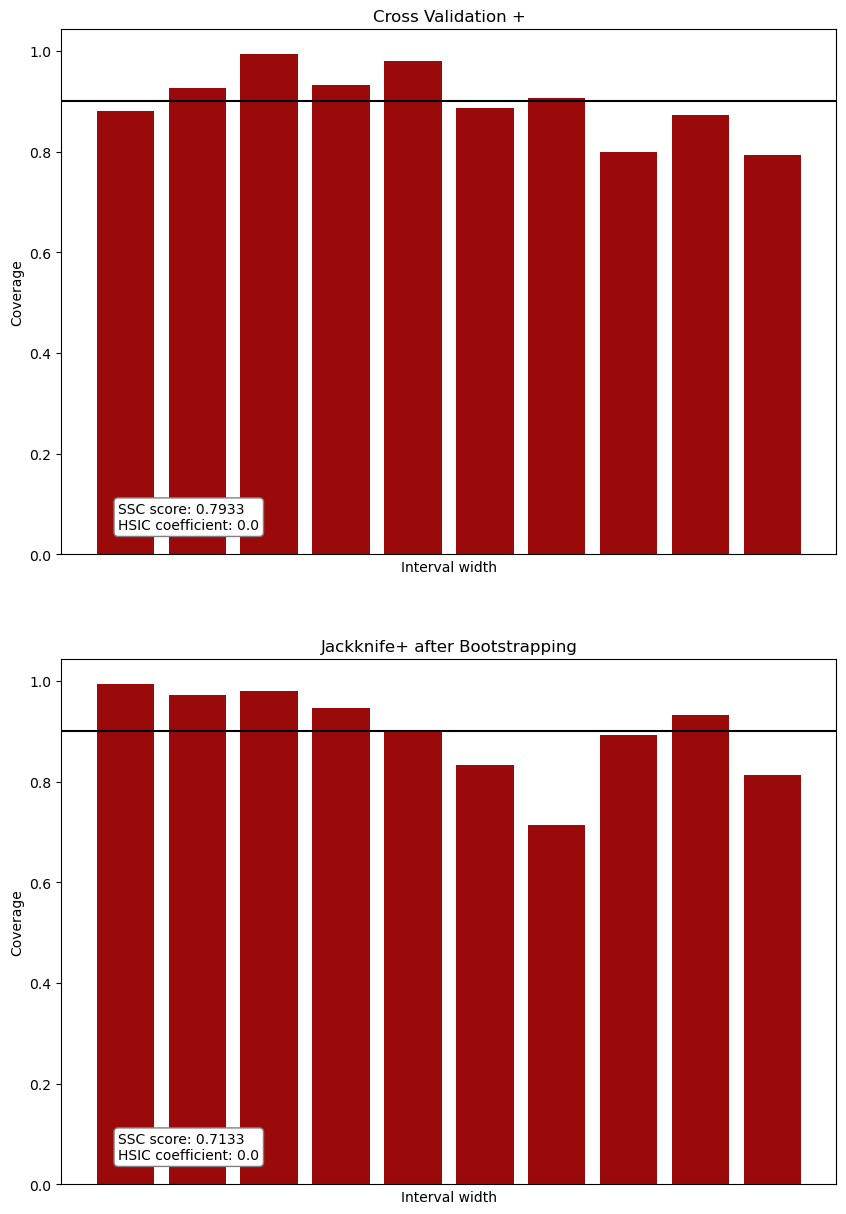

In [18]:
_strategies = [_s for _s in strategies_names.keys() if _s != 'SCP']
NUM_BINS: int = 10

fig, axs = plt.subplots(nrows=len(_strategies), figsize=(10, 15));

cond_coverages: dict = validate.cond_coverage(int_pred, y_test, num_bins=NUM_BINS)
hsic_coefficients: dict = validate.hsic_coefficient(int_pred, y_test) 

for _i, _strat in enumerate(_strategies):
    axs[_i] = visualize.coverage_by_width(
        y_test, int_pred[_strat], MISCOVERAGE,
        cond_coverages[_strat],
        hsic_coefficients[_strat],
        num_bins=NUM_BINS,
        ax=axs[_i],
        title=strategies_names[_strat], 
    )

- Metric list

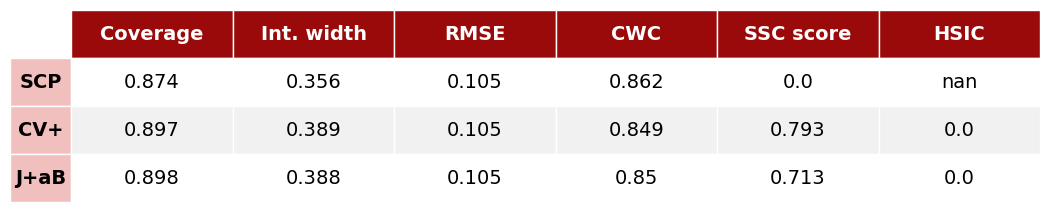

In [19]:
metrics_df = visualize.dicts_to_dataframe(
    {'Coverage': coverages, 'Int. width': widths, 
     'RMSE': rmse, 'CWC': cwc, 
     'SSC score': cond_coverages, 
     'HSIC': hsic_coefficients})

visualize.dataframe_to_png(metrics_df, 'output/metrics-table.png')

- **Coverage sougth for different values of $\alpha$**: and, finally, a visualization which displays the performance of each strategy when $\alpha$ is changed

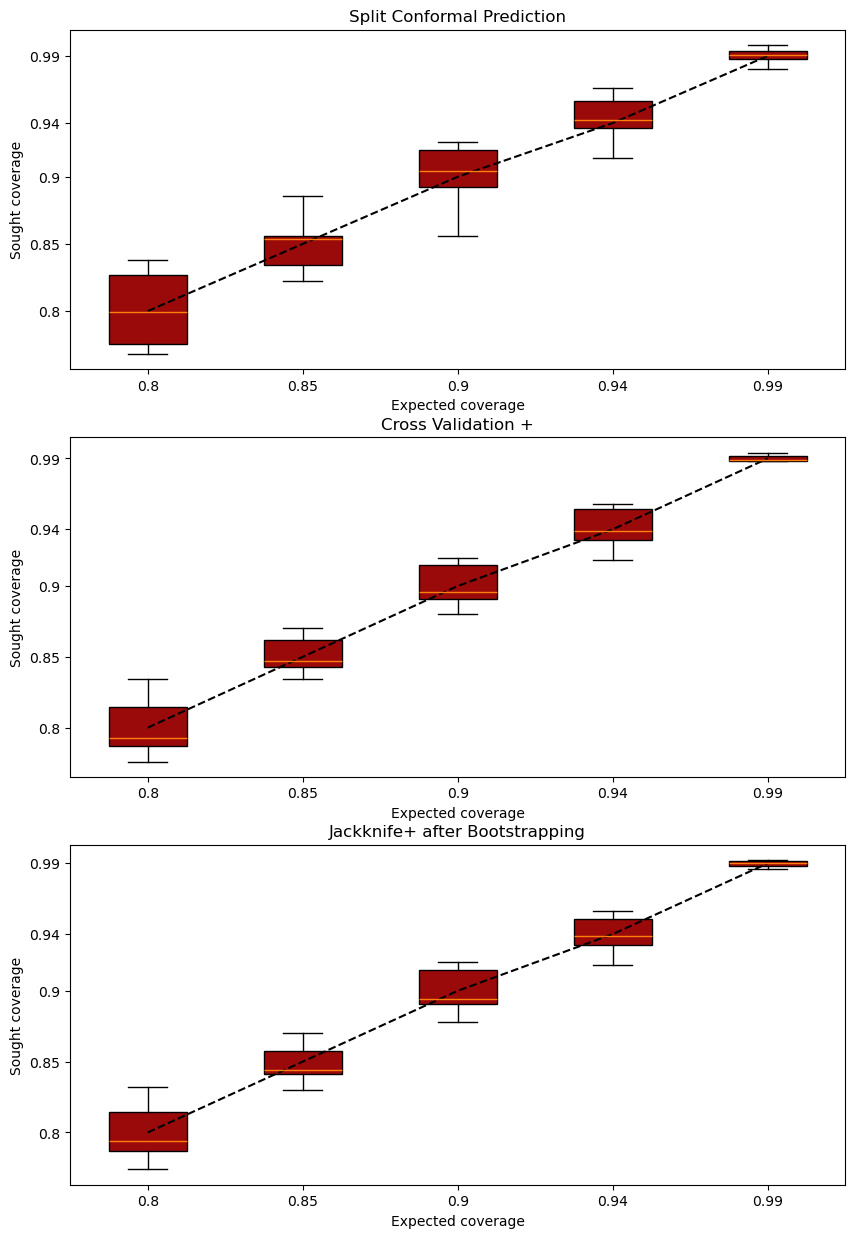

In [20]:
coverages_dict, miscoverages_list = {}, np.round(np.linspace(0.01, 0.20, 5), 2)
for _strat, base_estimator in base_estimators.items():
    coverages_dict[_strat] = cv.coverage_in_function_of_alpha(X, y, miscoverages_list, 
                                                              base_estimator, strategies_params[_strat], 
                                                              _strat, SEED, silent=True, K=10)
    
fig, axs = plt.subplots(nrows=len(base_estimators), figsize=(10, 15));

for _i, _strat in enumerate(base_estimators):
    axs[_i] = visualize.coverage_by_alpha(
        coverages_dict[_strat], 
        miscoverages_list, 
        strategies_names[_strat],
        ax=axs[_i]
        )